<a href="https://colab.research.google.com/github/trhieu2/hands-on-ml-practices/blob/main/classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 3: Classification

## Set up

In [ ]:
import sys

assert sys.version_info >= (3, 7)

In [ ]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

Define the default font sizes to make the figures prettier:

In [ ]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

And let's create the images/classification folder (if it doesn't already exist), and define the save_fig() function which is used through this notebook to save the figures in high-res for the book:

In [ ]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "classification"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## MNIST

In [ ]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

The sklearn.datasets package contains mostly three types of functions: fetch_*
functions such as fetch_openml() to download real-life datasets, load_* functions to
load small toy datasets bundled with Scikit-Learnand, and make_* functions to generate fake datasets, useful for tests.
Generated datasets are usually returned as an (X, y) tuple containing the input data and
the targets, both as NumPy arrays. Other datasets are returned as
sklearn.utils.Bunch objects, which are dictionaries whose entries can also be
accessed as attributes.

The fetch_openml() function is a bit unusual since by default it returns the inputs as a
Pandas DataFrame and the labels as a Pandas Series (unless the dataset is sparse). But
the MNIST dataset contains images, and DataFrames aren’t ideal for that, so it’s
preferable to set as_frame=False to get the data as NumPy arrays instead. Let’s look at
these arrays:

In [ ]:
X, y = mnist.data, mnist.target
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
X.shape

(70000, 784)

In [ ]:
y.shape

(70000,)

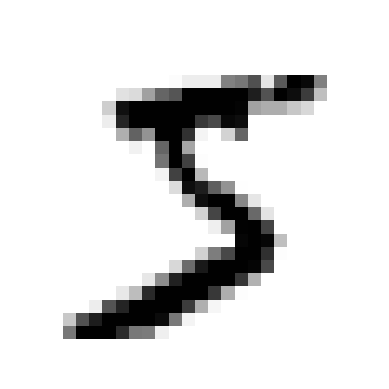

In [ ]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
  image = image_data.reshape(28,28)
  plt.imshow(image, cmap="binary")
  plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)
plt.show()

In [ ]:
y[0]

'5'

In [ ]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary classifier

Simpifying the problem to just indentify one digit

In [ ]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

Start with SGD classifier

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [ ]:
sgd_clf.predict([some_digit])

array([ True])

## Performance measures

### Measuring accuracy using cross-validation

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Above 95% accuracy!

In [ ]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train))) #print False: no 5s detected

False


In [ ]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

This means if you always guess that an image is not a 5, you will be right about 90% of the time

This demonstrates why accuracy is generally not the preferred performance measure for classifers, esp. when your dealing with skewed datasets.

### Confusion matrices

In [ ]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]])

Each row representing actual class, while each column represents a predicted class.

687 false positives and 1891 false negatives

A perfect classifer would only have true postives and true negatives.

But sometimes you will prefer a more consie metric. An interesting look at is the accuracy of the positive predictions -> this is called the precision of the classifier.

Recall aka sensitivity or the true positive rate (TPR): this is the ratio of the positive instances that are correctly detected by the classifer

### Precision and recall

In [ ]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [ ]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

It's often convenient to combine precision and recall into a signle metric called the F1 score, esp. when you need a single metric to compare two classifiers.

The F1 score means harmonic mean of precision and recall to compare two classifiers

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343847

F1 scores favor classifiers that have similar precision and recall. This is not always what you want.

Unfortunately, you can't have it both ways, increasing precision reduces recall and vice versa -> This is called recall/precision tradeoff

### The precision/recall trade-off

The SGDClassifier computes a score based on a decision function. If that score is greater than a threshold -> positive, otherwise. Increasing the threshold reducing recall score. Conversely, lowering the threshold increases recall and reduces precision.

Instead of calling the classifier's predict() method, we can call its decition_ function() method, which returns a score for each instance. You can then use any threshold you want to make predictions based on those scores.

How you decide which threshold to use? One option is to use the cross_val_predicct() function to get the scores of all instances in the training set, but this time specify that you want to return decision scores instead of predictions:

In [ ]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

With these scores, use the precision_recall_curve() function to compute precision and recall for all possible thresholds

In [ ]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

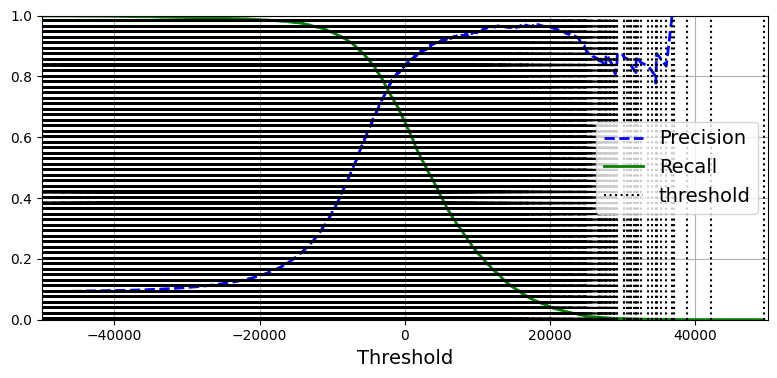

In [27]:
plt.figure(figsize=(8, 4))  # extra code – it's not needed, just formatting
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(thresholds, 0, 1.0, "k", "dotted", label="threshold")

# extra code – this section just beautifies and saves Figure 3–5
idx = (thresholds >= thresholds).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")
save_fig("precision_recall_vs_threshold_plot")

plt.show()

Another way to select a good precision/recall trade-off is to plot precision directly against recall.

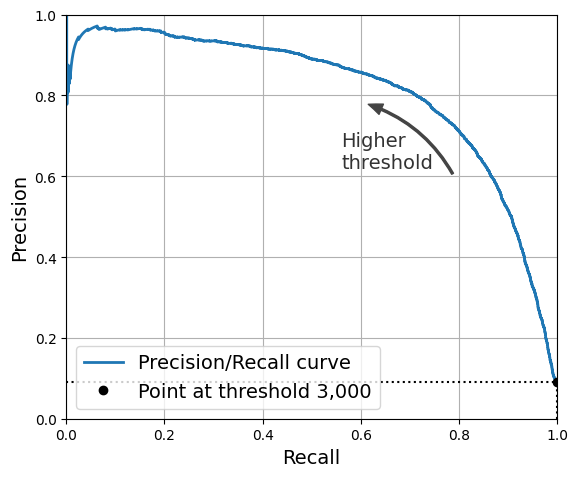

In [28]:
import matplotlib.patches as patches  # extra code – for the curved arrow

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

# extra code – just beautifies and saves Figure 3–6
plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="Point at threshold 3,000")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
save_fig("precision_vs_recall_plot")

plt.show()

Searching for the lowest threshold that gives you 90% precision.

In [29]:
idx_for_90_precision = (precisions>=0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

np.float64(3370.0194991439557)

In [30]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

In [31]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [33]:
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision

0.4799852425751706

### ROC curve

The receiver operating characteristic (ROC) cureve is another common tool used with binary classifier. ROC curve plots the TP rate (another name for recall) against the false positive rate (FPR) (also called the fall-out) is the ratio of negative instances that are incorrectly classified as positive. It is equal to 1 - the true negative rate (TNR) (aka specificity). Hence, the ROC curve plots sensitivity verse 1 - specificity.

In [35]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

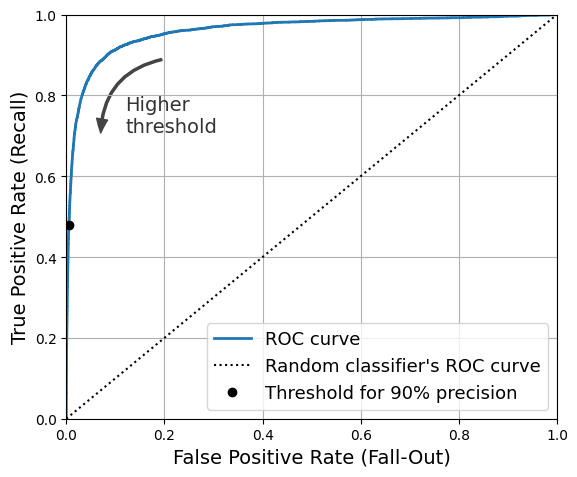

In [36]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

# extra code – just beautifies and saves Figure 3–7
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)
save_fig("roc_curve_plot")

plt.show()